<a href="https://colab.research.google.com/github/Inbal-Schekler/UNET-flocks-detection/blob/main/UNET_Soaring_birds_model_f.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Imports**

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
from keras import metrics
from keras import regularizers
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle
from datetime import datetime
import re
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

Using TensorFlow backend.


##**Data**
####Unzipping the data folder 
####The link is in the README file
####First drug the folder to the files in colab and than unzip it

In [ ]:
!unzip '/content/train_test.zip' -d "/content/train_test/"



Streaming output truncated to the last 5000 lines.
  inflating: /content/train_test/Data_github/train/Meron_summer/2019/06/12/1314--20190612-032242_VRADH.tiff  
  inflating: /content/train_test/Data_github/train/Meron_summer/2019/06/12/1314--20190612-032536_VRADH.tiff  
  inflating: /content/train_test/Data_github/train/Meron_summer/2019/06/12/1314--20190612-032830_VRADH.tiff  
  inflating: /content/train_test/Data_github/train/Meron_summer/2019/06/12/1314--20190612-033124_VRADH.tiff  
  inflating: /content/train_test/Data_github/train/Meron_summer/2019/06/12/1314--20190612-033418_VRADH.tiff  
  inflating: /content/train_test/Data_github/train/Meron_summer/2019/06/12/1314--20190612-033712_VRADH.tiff  
  inflating: /content/train_test/Data_github/train/Meron_summer/2019/06/12/1314--20190612-034006_VRADH.tiff  
  inflating: /content/train_test/Data_github/train/Meron_summer/2019/06/12/1314--20190612-034300_VRADH.tiff  
  inflating: /content/train_test/Data_github/train/Meron_summer/2019/

####Cloning github repository for the functions

In [2]:
! git clone https://github.com/Inbal-Schekler/UNET-flocks-detection

Cloning into 'UNET-flocks-detection'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 124 (delta 25), reused 0 (delta 0), pack-reused 72
Receiving objects: 100% (124/124), 2.24 MiB | 27.69 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [5]:
os.chdir('/content/UNET-flocks-detection/functions')

### **Dataset**


Note that In each floder we have tiff images (the radial velocity radar parametr) and png images (the annotated images)
.

In [8]:

### list of train images


train_files_n = glob.glob ('/content/train_test/Data_github/train/*/*/*/*/*.tiff')

# sort the file by the data and time
train_files= sorted(train_files_n,key=lambda file: datetime.strptime(re.search('--(.*)_', os.path.basename(file)).group(1).replace('-', ' '), '%Y%m%d %H%M%S'))

print("length of train files",len(train_files))



### list of test images

test_files_n = glob.glob('/content/train_test/Data_github/test/*/*/*/*/*.tiff')

test_files= sorted(test_files_n,key=lambda file: datetime.strptime(re.search('--(.*)_', os.path.basename(file)).group(1).replace('-', ' '), '%Y%m%d %H%M%S'))

print("length of test files",len(test_files))


length of train files 6276
length of test files 1370


Functions to import (from github)

In [6]:
from create_previous_images import create_early_image_2
from generators import image_generator
from unet_model import unet



##**Generators**


In [9]:
box = (29, 29, 450, 450)
num_past=2 
minuts=7
batch_size = 32
sz = (256, 256)

train_generator = image_generator(train_files,num_past=num_past,minuts=minuts, box=box, batch_size = batch_size)
test_generator  = image_generator(test_files,num_past=num_past,minuts=minuts,box = box ,batch_size = batch_size)

In [ ]:
x, y= next(train_generator)
print (x.shape)
print(y.shape)

(32, 256, 256, 9)
(32, 256, 256, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Mask over image')

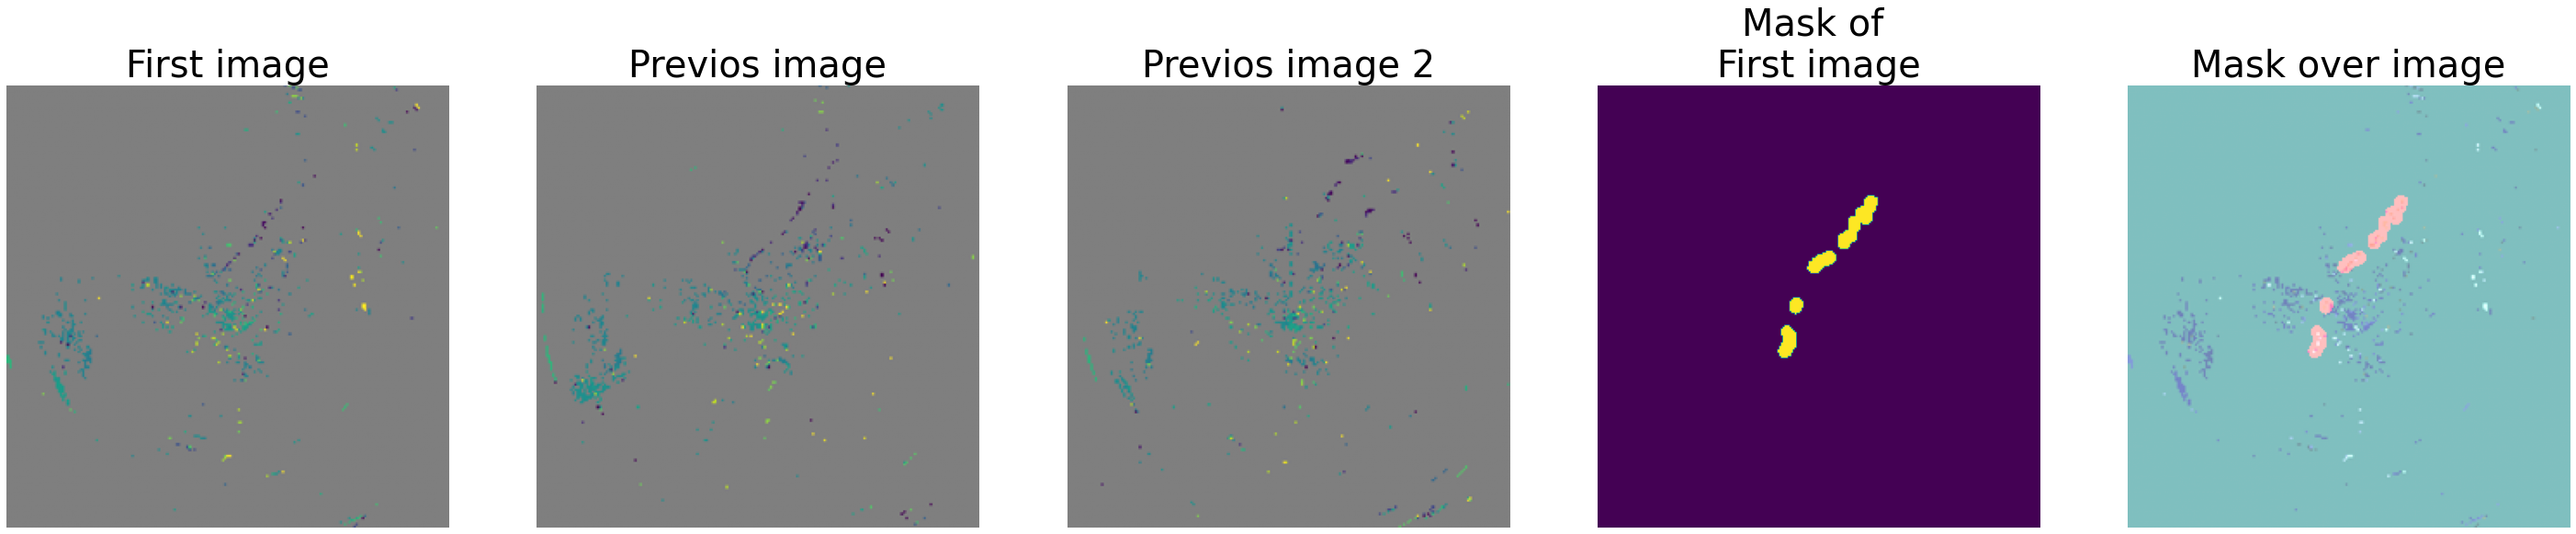

In [ ]:

img_2 = x[20]
## the first image
img=img_2[:,:,0:3]

## the previos image
img_prev=img_2[:,:,3:6]

## two images before
img_prev_2 = img_2[:,:,6:9]

## the tagged image
msk = y[20]


# Make a True/False mask of pixels whose BGR values sum to more than zero
alpha = np.sum(msk, axis=-1) > 0
unique, counts = np.unique(alpha, return_counts=True)
alpha_2 = np.sum(msk) > 0


# Convert True/False to 0/255 and change type to "uint8" to match "na"
alpha = np.uint8(alpha * 255)


# Stack new alpha layer with existing image to go from BGR to BGRA, i.e. 3 channels to 4 channels
res = np.dstack((alpha, img))


f, axarr = plt.subplots(1,5, figsize=(50,50))
axarr[0].imshow(img)
axarr[0].axis ('off')
axarr[0].set_title('First image',fontsize=40)

axarr[1].imshow(img_prev)
axarr[1].axis ('off')
axarr[1].set_title('Previos image',fontsize=40)

axarr[2].imshow(img_prev_2)
axarr[2].axis ('off')
axarr[2].set_title('Previos image 2',fontsize=40)

axarr[3].imshow(msk.squeeze())
axarr[3].axis ('off')
axarr[3].set_title('Mask of \nFirst image',fontsize=40)

axarr[4].imshow(res)
axarr[4].axis ('off')
axarr[4].set_title('Mask over image',fontsize=40)


### **The model**

In [18]:
model = unet()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 9)  0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 256, 256, 8)  656         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 256, 256, 8)  584         conv2d_28[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 128, 128, 8)  0           conv2d_29[0][0]                  
____________________________________________________________________________________________

### **Callbacks**



Functions to save the model at each epoch and show some predictions while running

In [19]:
def build_callbacks():
        filepath = 'my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'
        checkpointer = ModelCheckpoint(filepath=filepath, verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer]
        
        return callbacks

###**Training**

In [20]:
train_steps = len(train_files) //batch_size

test_steps = len(test_files) //batch_size


history=model.fit_generator(train_generator,               
                    epochs = 60, steps_per_epoch = train_steps,validation_data = test_generator, validation_steps = test_steps,
                     callbacks = build_callbacks(),verbose = 1)



Epoch 1/60
196/196 [==============================] - 119s 605ms/step - loss: 0.1375 - accuracy: 0.9805 - val_loss: 0.0417 - val_accuracy: 0.9930
Epoch 2/60
196/196 [==============================] - 113s 577ms/step - loss: 0.0677 - accuracy: 0.9858 - val_loss: 0.0282 - val_accuracy: 0.9932
Epoch 3/60
196/196 [==============================] - 113s 577ms/step - loss: 0.0576 - accuracy: 0.9858 - val_loss: 0.0392 - val_accuracy: 0.9930
Epoch 4/60
196/196 [==============================] - 113s 578ms/step - loss: 0.0509 - accuracy: 0.9857 - val_loss: 0.0277 - val_accuracy: 0.9924
Epoch 5/60
196/196 [==============================] - 113s 577ms/step - loss: 0.0430 - accuracy: 0.9864 - val_loss: 0.0204 - val_accuracy: 0.9932
Epoch 6/60
196/196 [==============================] - 113s 578ms/step - loss: 0.0357 - accuracy: 0.9881 - val_loss: 0.0254 - val_accuracy: 0.9935
Epoch 7/60
196/196 [==============================] - 113s 577ms/step - loss: 0.0318 - accuracy: 0.9888 - val_loss: 0.0219 -

Saving the model and the history results

In [21]:
model.save('unet_2_prev_images')


with open('trainHistoryDict_unet_2_prev_images', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

The performance figures





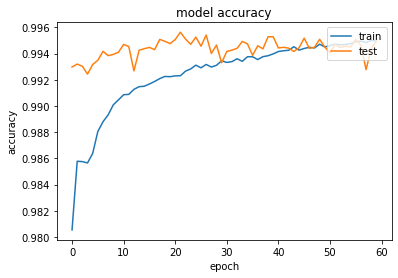

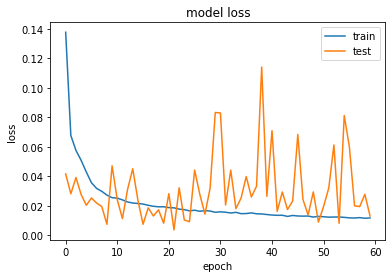

In [22]:
## plot the figurs of accuracy, loss and IOU

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
